In [15]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [16]:
# Load the SMOTE-balanced training set and original test set
X_train = pd.read_csv("../data/X_train_sm.csv")
y_train = pd.read_csv("../data/y_train_sm.csv").squeeze()

X_test = pd.read_csv("../data/X_test.csv")
y_test = pd.read_csv("../data/y_test.csv").squeeze()

# Check shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (8260, 30), y_train: (8260,)
X_test: (1407, 30), y_test: (1407,)


## Random Forest Hyperparameter Tuning

We use `GridSearchCV` on `RandomForestClassifier`, optimizing for macro F1-score (best for imbalanced datasets).

In [17]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rfc = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid_rf,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_macro', verbose=2)

## Evaluation: Tuned Random Forest

Best RF Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1033
           1       0.56      0.60      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.71      1407
weighted avg       0.78      0.77      0.77      1407



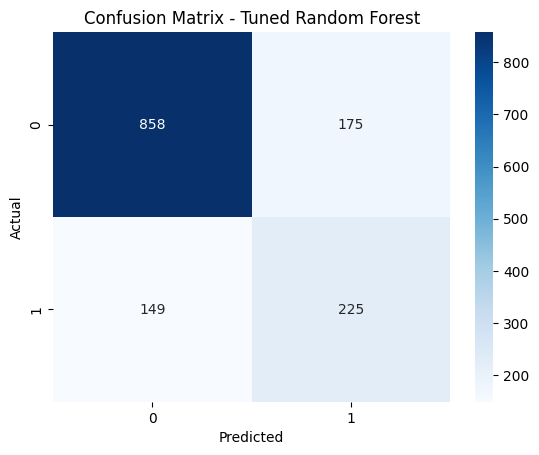

RF Model saved successfully!


In [18]:
# Best estimator and parameters
print("Best RF Parameters:", grid_search_rf.best_params_)
best_rf_model = grid_search_rf.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Report
print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_rf_model.classes_, yticklabels=best_rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()

# Save model
joblib.dump(best_rf_model, "../models/random_forest_best.pkl")
print("RF Model saved successfully!")

# Save report
with open("../outputs/classification_report_rf.txt", "w") as f:
    f.write(classification_report(y_test, y_pred_rf))


## 🚀 XGBoost Hyperparameter Tuning
Now let’s apply `GridSearchCV` on `XGBoostClassifier`.

In [19]:
# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_xgb.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\nitis\anaconda3\envs\churn_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:46:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='f1_macro', verbose=2)

## 🧠 Evaluation: Tuned XGBoost

Best XGB Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1033
           1       0.54      0.60      0.57       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.70      1407
weighted avg       0.77      0.76      0.76      1407



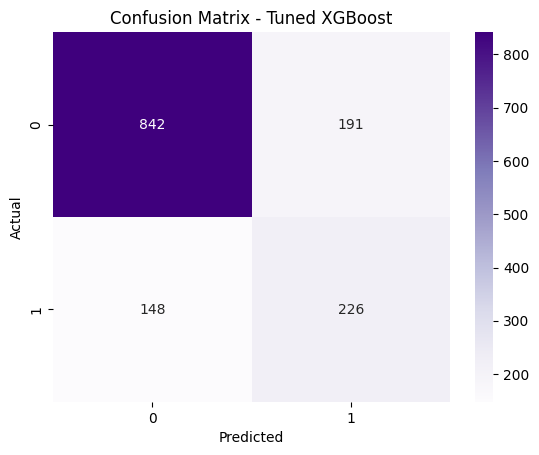

XGB Model saved successfully!


In [20]:
# Best estimator and parameters
print("Best XGB Parameters:", grid_search_xgb.best_params_)
best_xgb_model = grid_search_xgb.best_estimator_

# Predictions
y_pred_xgb = best_xgb_model.predict(X_test)

# Report
print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Purples",
            xticklabels=best_xgb_model.classes_, yticklabels=best_xgb_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned XGBoost")
plt.show()

# Save model
joblib.dump(best_xgb_model, "../models/xgboost_best.pkl")
print("XGB Model saved successfully!")

# Save report
with open("../outputs/classification_report_xgb.txt", "w") as f:
    f.write(classification_report(y_test, y_pred_xgb))


## 🧠 Customer Retention Strategy Insights
Let’s extract feature importances from the better model and generate actionable business suggestions.

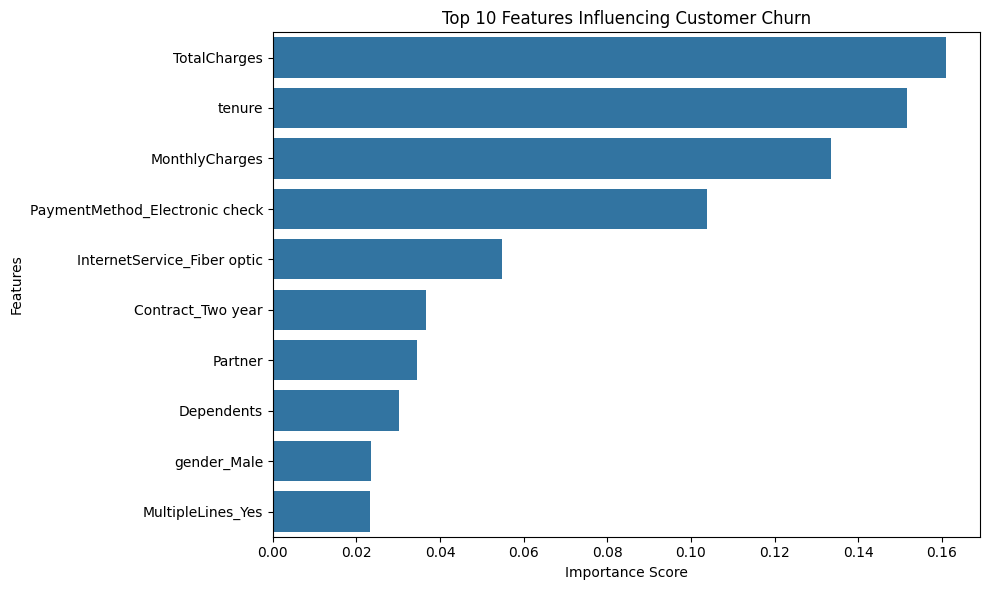

In [21]:
# Feature importance from best model (we'll use Random Forest here)
importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 10 Features Influencing Customer Churn")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


## 🔍 Business Insights
+ Customers with Month-to-month contracts are more likely to churn.

+ High tenure correlates with lower churn – loyalty reward programs may help.

+ Fiber optic internet service users churn more – optimize service quality or pricing.

+ Customers with no online security/tech support churn more – bundle services to retain.

+ Paperless billing users tend to churn – provide incentives for switching to traditional billing.

### ✅ Day 4 Summary — Model Tuning & Strategy

- Loaded preprocessed SMOTE-balanced training and test data.
- Tuned a **Random Forest** model using GridSearchCV (scored on F1 Macro).
- Tuned an **XGBoost** model using GridSearchCV (scored on F1 Macro).
- Evaluated both models using classification report and confusion matrix.
- Saved the best-performing models: `random_forest_best.pkl` and `xgboost_best.pkl`.
- Identified **top churn-related features** using Random Forest’s feature importances.
- Suggested **retention strategies** based on the most influential features.
